In this notebook, we will experiment:  
- Chunking and not chunking documents
- Manuel embedding of documents with OpenAI's embedding models
- try some OpenAI GPT3.5Turbo compatible open source embedding models
- ETL processes with a vector database (Pinecone - API needed)
- Recompiling the Rag system

# Import Dependencies

In [9]:
import json
import os
import tiktoken
import openai
import pandas as pd
from pinecone import Pinecone, ServerlessSpec
import numpy as np
from sentence_transformers import SentenceTransformer

import warnings
warnings.filterwarnings('ignore')
from dotenv import load_dotenv
load_dotenv()

True

## Calculate Token Count for our Corpus

In [2]:
# Load the JSON file
with open('rag_dataset.json', 'r', encoding='utf-8') as file:
    rag_dataset = json.load(file)

In [7]:
def token_counter(json_corpus):
    # Initialize token count
    total_tokens = 0

    # Load the tokenizer
    tokenizer = tiktoken.get_encoding("cl100k_base")

    # Iterate over each document and count tokens
    for doc in json_corpus:
        content = doc["content"]
        tokens = tokenizer.encode(content)
        num_tokens = len(tokens)
        total_tokens += num_tokens
        print(f"Document ID: {doc['source_id']}, Tokens: {num_tokens}")
    return total_tokens

total_tokens = token_counter(rag_dataset)
print(f"Total number of tokens in the corpus: {total_tokens}")

Document ID: 1, Tokens: 4192
Document ID: 2, Tokens: 2171
Document ID: 3, Tokens: 3567
Document ID: 4, Tokens: 2422
Document ID: 5, Tokens: 2398
Document ID: 6, Tokens: 1758
Document ID: 7, Tokens: 748
Document ID: 8, Tokens: 4468
Document ID: 9, Tokens: 724
Document ID: 10, Tokens: 2568
Document ID: 11, Tokens: 1320
Document ID: 12, Tokens: 2783
Document ID: 13, Tokens: 833
Document ID: 14, Tokens: 3516
Document ID: 15, Tokens: 2595
Total number of tokens in the corpus: 36063


# Open Source Embedding Models

In [6]:
# Load the embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Load the JSON file
with open('rag_dataset.json', 'r', encoding='utf-8') as file:
    rag_dataset = json.load(file)

# Generate embeddings for each document
embeddings = []
documents = []

for doc in rag_dataset:
    text = doc["content"]
    embedding = model.encode(text)
    embeddings.append(embedding)
    documents.append(doc)

# Convert embeddings to numpy array for FAISS
import numpy as np
embeddings_np = np.array(embeddings)

print(f"Generated {len(embeddings_np)} embeddings.")


Generated 15 embeddings.


In [7]:
print(f"Embeddings Dimensions: {len(embeddings_np[0])}")
print(f"A Sample embedded document: \n{embeddings_np[0]}")

Embeddings Dimensions: 384
A Sample embedded document: 
[ 3.09171025e-02 -8.90537500e-02  6.76948391e-03  3.95752415e-02
  1.72852557e-02  3.76281440e-02  1.14817061e-02  4.72218096e-02
  5.96322026e-03 -2.01059319e-02  4.57130596e-02  4.14200760e-02
  9.00535211e-02 -6.49557486e-02  8.36676508e-02 -4.68865633e-02
 -3.66019458e-03 -6.11607432e-02 -1.29569650e-01 -8.75317156e-02
 -2.04631202e-02 -3.43305580e-02 -5.38553037e-02  4.01871093e-02
 -6.29546866e-02  4.50878823e-03 -3.57312337e-02  2.50323713e-02
 -4.27301088e-03 -5.92251234e-02  3.11274882e-02 -4.11407575e-02
  5.19546494e-02  1.13811102e-02 -2.74917576e-02 -8.67018104e-02
 -4.89594601e-02 -7.64432624e-02  5.54890418e-03 -1.90153904e-02
  2.71983258e-02 -7.16128349e-02 -1.46555394e-01  1.57067049e-02
  4.69347928e-03  7.80275371e-03  5.60158193e-02  7.76518360e-02
  9.60370377e-02  1.93958115e-02 -2.38058660e-02  6.85073808e-03
 -6.18773662e-02 -4.51652631e-02 -8.78126323e-02  4.89109904e-02
 -2.18965448e-02 -3.96368690e-02  

## Pinecone: Create Index, Store and Retrieve

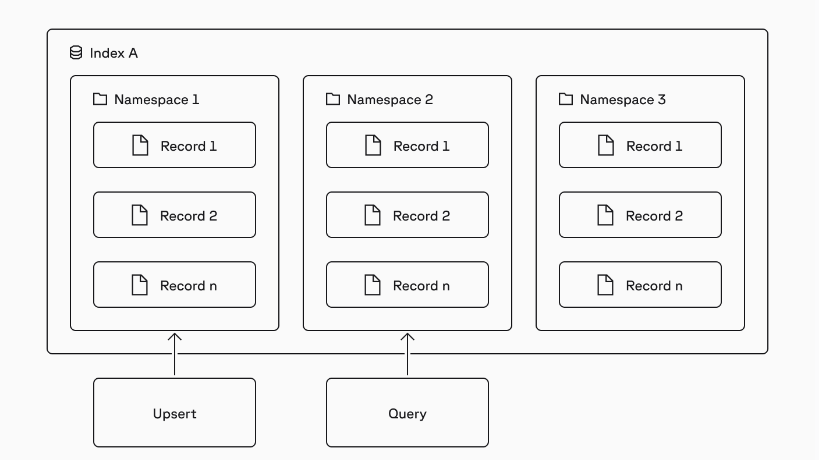

**Index:** A structure to store and organize your vectors.  
**Namespace:** A logical partition within an index to separate different sets of vectors.  
**Upsert:** An operation to add or update vectors in an index.  
**Query:** A search request to find vectors similar to a given query vector.  
**Record:** An individual data entry in your index, including the vector, ID, and metadata.  

In [10]:
# Initialize Pinecone clinet connection
pinecone_api = os.getenv('PINECONE_API_KEY')
pc = Pinecone(api_key= pinecone_api)

In [12]:
pc.list_indexes()

# currently we dont have any indexes in this pinecone client

{'indexes': []}

In [14]:
# Create a serverless index
index_name = "rag-amazon-mini384"

if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=384,
        metric="cosine",
        spec=ServerlessSpec(
            cloud='aws', 
            region='us-east-1'
        ) 
    ) 

In [ ]:
# we are targeting our rag-amazon-mini384 index
index = pc.Index("rag-amazon-mini384")

# Lets UPSERT / put these embedding vectors (to index) into pinecone vector database
index.upsert(
    vectors=
)

In [ ]:
# Create the chat engine
chat_engine = index.as_chat_engine(chat_mode="condense_question", verbose=False)

if prompt := st.chat_input(
    "Your question"
):  # Prompt for user input and save to chat history
    st.session_state.messages.append({"role": "user", "content": prompt})

for message in st.session_state.messages:  # Display the prior chat messages
    with st.chat_message(message["role"]):
        st.write(message["content"])

# If last message is not from assistant, generate a new response
if st.session_state.messages[-1]["role"] != "assistant":
    with st.chat_message("assistant"):
        with st.spinner("Thinking..."):
            response = chat_engine.chat(prompt)
            st.write(response.response)
            message = {"role": "assistant", "content": response.response}
            st.session_state.messages.append(message)  # Add response to message history

# OpenAI's embedding Model

In [13]:
# Set your OpenAI API key
openai.api_key = os.getenv("OPENAI_API_KEY")

client = openai.OpenAI()